In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import seaborn as sns
from scipy import stats

Through initial attempt to open the csv using pd.read_csv(), I found some rows with 3 columns. since the dataset has 272 observations on two variables, these rows were discarded.

In [2]:
df_tmp = []
with open  ('geyser.csv') as f:
    reader = csv.reader(f)
    #print(reader)
    for row in reader:
      #print(len(row))
      if len(row) == 2:
        df_tmp.append(row)

df = pd.DataFrame(df_tmp)
df

,0,1
0,# The description of dataset has been preserve...,but the dataset itself
1,# If you are in BMI 500,then use this dataset and not the source data.
2,# Hardle,W. (1991) Smoothing Techniques with Implement...
3,# Old Faithful geyser. Applied Statistics 39,357-365.
4,eruptions,waiting
...,...,...
272,4.117,81
273,2.150,46
274,4.417,90
275,1.817,46


In [3]:
number_df = df.iloc[5:].copy()
number_df.columns = df.iloc[4]
number_df = number_df.reset_index(drop=True)
number_df.shape

(272, 2)

The number_df suits the desired shape of dataset.

### Anomoly Detection and Data Preprocessing

In [4]:
# non-numerical values
for row in number_df.index:
  for col in number_df.columns:
    check = number_df.loc[row, col]
    if pd.isna(pd.to_numeric(check, errors='coerce')):
      print(row, col, check, type(check))

20 eruptions 1 800 <class 'str'>
57 eruptions l.667 <class 'str'>
64 waiting 6O <class 'str'>


In [5]:
# fix the non-numerical entires
number_df.iloc[20, 0] = 1800 # Since 1800 minutes of eruption is unreasonable, it's more possible to be 1.800 minutes. However, to remain unbaised, I decide to omit this row.
number_df.iloc[57, 0] = 1.667
number_df.iloc[64, 1] = 60

### Wenfeng Comment ###
# Suggestion for improvement: Instead of using `iloc` with "magic numbers" like 20, 57, and 64, it's better to use conditional selection with `.loc`.

In [6]:
# verify the result
for row in number_df.index:
  for col in number_df.columns:
    check = number_df.loc[row, col]
    if pd.isna(pd.to_numeric(check, errors='coerce')):
      print(row, col, check, type(check))
print(number_df.dtypes)

# update the type of entry
numeric_df = number_df.apply(pd.to_numeric, errors='coerce')
print(numeric_df.dtypes)

4
eruptions    object
waiting      object
dtype: object
4
eruptions    float64
waiting        int64
dtype: object


In [7]:
# data summary for the range of data
mean_values = numeric_df.mean()
min_values = numeric_df.min()
max_values = numeric_df.max()
mmm_tb = pd.concat([mean_values, min_values, max_values], axis=1)
mmm_tb.columns = ['mean', 'min', 'max']
mmm_tb

,mean,min,max
4,,,
eruptions,177.636132,1.6,41083.0
waiting,70.566176,5.0,96.0


The max of eruption is unexpectedly large

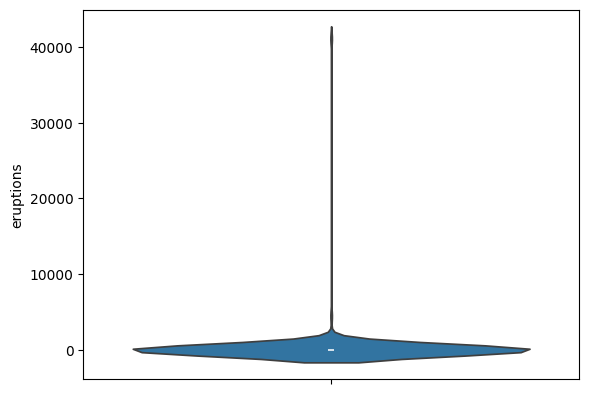

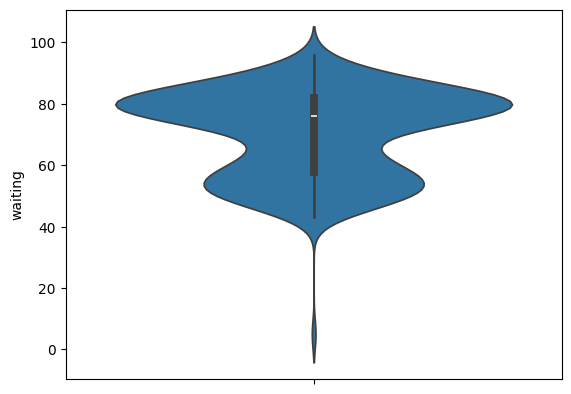

In [8]:
# the bad plot
for col in numeric_df.columns:
    sns.violinplot(y=numeric_df[col])
    plt.show()

/tmp/ipython-input-4213734533.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=numeric_df[col], palette="pastel", inner="quartile", linecolor= 'black', linewidth=1.5)


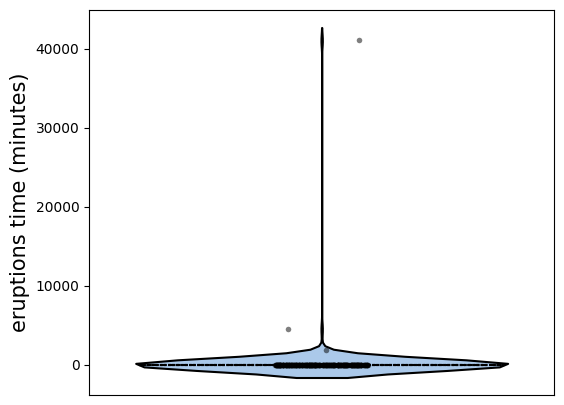

/tmp/ipython-input-4213734533.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=numeric_df[col], palette="pastel", inner="quartile", linecolor= 'black', linewidth=1.5)


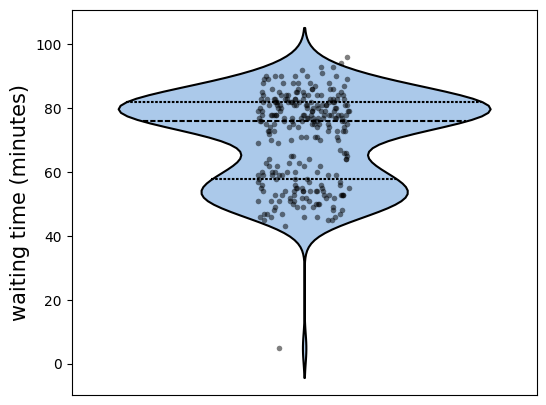

In [9]:
# a better plot
for col in numeric_df.columns:
    plt.figure(figsize=(6, 5))
    sns.violinplot(y=numeric_df[col], palette="pastel", inner="quartile", linecolor= 'black', linewidth=1.5)
    sns.stripplot(y=numeric_df[col], color='black', size = 4, alpha = 0.5, jitter=True)
    plt.ylabel(f"{col} time (minutes)", fontsize=15)
    plt.xticks([])
    plt.show()

Many outliers in eruption time

In [10]:
numeric_df.shape

(272, 2)

In [11]:
numeric_df[numeric_df['eruptions'] > 5]

4,eruptions,waiting
20,1800.000,51
75,5.067,76
148,5.100,96
152,5.033,77
230,41083.000,70
261,4500.000,84


Since most erruption time are less than 5 minutes, the erruption time of 41083 minutes and 4500 minutes is unreasonable. Especially, when its waiting time is similar to that of others. Therefore, I omitted these rows.

In [12]:
numeric_df[numeric_df['waiting'] < 46]

4,eruptions,waiting
116,2.317,5
126,1.917,45
130,1.867,45
162,2.200,45
264,1.983,43


There are very little rows with waiting time less than 46 minutes. A waiting time of 5 minutes might be plausible in real life. Therefore, we should employ statistical methods to examine its possibility.

In [13]:
z_scores = stats.zscore(numeric_df['waiting'])
outliers = numeric_df[abs(z_scores) > 3]
outliers

4,eruptions,waiting
116,2.317,5


Three standard deviations away from the mean indicated its unsual distance from the mean. Therefore, I will remove this row.

In [14]:
sized_df = numeric_df[numeric_df['eruptions'] <= 6]
sized_df = sized_df.drop(index=116)
sized_df.shape

(268, 2)

### Wenfeng Comment ###
# Your comment mentions deciding to omit the row with "1800", but the code in `In [5]` actually changes it. The final `sized_df` creation correctly filters it out. It would be good practice to remove the value directly rather than correcting it first if the intention is to discard it.

In [15]:
mean_values = sized_df.mean()
min_values = sized_df.min()
max_values = sized_df.max()
mmm_tb2 = pd.concat([mean_values, min_values, max_values], axis=1)
mmm_tb2.columns = ['mean', 'min', 'max']
mmm_tb2

,mean,min,max
4,,,
eruptions,3.476534,1.6,5.1
waiting,70.835821,43.0,96.0


/tmp/ipython-input-1660736734.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=sized_df[col], palette="pastel", inner="quartile", linecolor= 'black', linewidth=1.5)


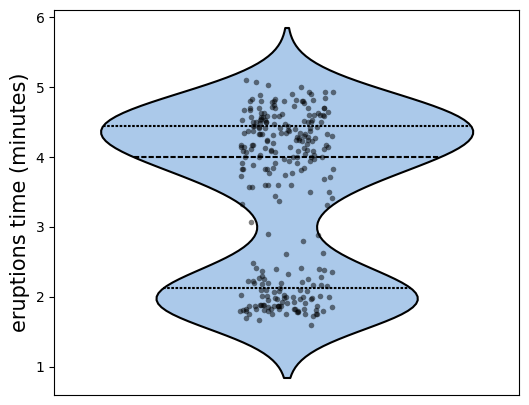

/tmp/ipython-input-1660736734.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(y=sized_df[col], palette="pastel", inner="quartile", linecolor= 'black', linewidth=1.5)


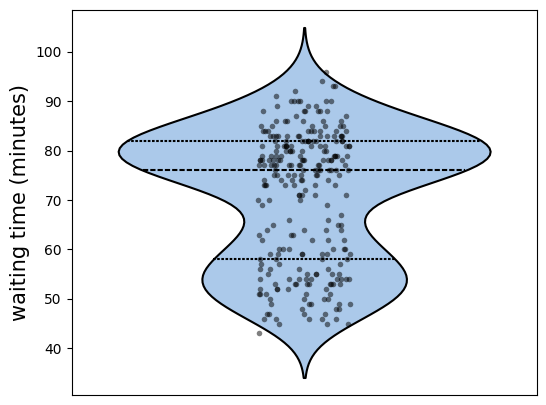

In [17]:
for col in sized_df.columns:
    plt.figure(figsize=(6, 5))
    sns.violinplot(y=sized_df[col], palette="pastel", inner="quartile", linecolor= 'black', linewidth=1.5)
    sns.stripplot(y=sized_df[col], color='black', size = 4, alpha = 0.5, jitter=True)
    plt.ylabel(f"{col} time (minutes)", fontsize=15)
    plt.xticks([])
    plt.show()

To determine the x axis and y axis of the graph. Let's see what question can we asking using each of the combination.
1. x-axis: waiting time. y-axis: eruption time. what is the eruption time as waiting time changes.
2. x-axis: eruption time. y-axis: waiting time. what is the waiting time as eruption time changes.

The first question is a bit un-intuitive, since the waiting time comes after the eruption. However, it might be useful for reseachers to predict the eruption intensity based on wait time.
The second question is of-interest to tourists, since they would want to know how long to wiat until the next one. However, both question should draw similar conclusions on the relationship between eruption time and waiting time, and I will focus on the second question.

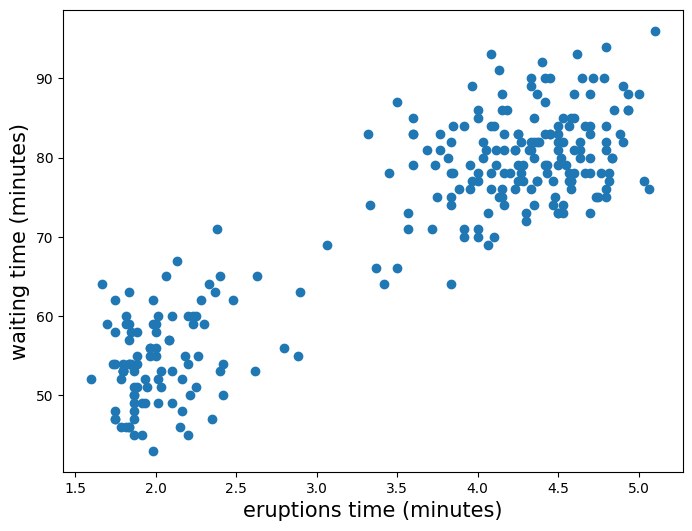

In [19]:
plt.figure(figsize=(8,6))
plt.scatter(sized_df['eruptions'], sized_df['waiting'])
plt.xlabel('eruptions time (minutes)', fontsize = 15)
plt.ylabel('waiting time (minutes)', fontsize = 15)
plt.show()

The eruption time and the waiting time have a positive correlation, and there are 2 clsuters, long eruptions VS short eruptions.